In [2]:
%matplotlib inline
from googleapiclient.discovery import build
import xlrd
import pprint
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import ConditionalFreqDist 
from nltk.probability import FreqDist 

nltk.download('stopwords') 
nltk.download('punkt')
set(stopwords.words('spanish'))
nltk.download('wordnet')

#$ pip install ipyupload
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package wordnet to /Users/aideenf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Set the Google custom search API credentials

In [3]:
my_api_key = PUT_KEY_HERE  
my_cse_id = PUT_ID_HERE

# Select the spreadsheet containing the goal keywords

In [4]:
dfGoals = pd.read_excel('goal_keywords.xlsx')

# Select the spreadsheet containing the search terms

In [5]:
dfSearchTerms = pd.read_excel('search_phrases.xlsx')

list(dfSearchTerms.columns.values)

['Search phrase']

In [6]:
dfSearchTerms.head(5)

,Search phrase
0,trajes zara hombre precios
1,trajes hombre zara precios
2,trajes zara precios
3,zara precios
4,ropa zara precios


In [7]:
dfGoals.head(5)

,Keyword,Goal,Weight,Region
0,website,brand,1,es
1,marca,brand,1,es
2,productos,brand,1,es
3,shop,brand,1,es
4,ww,brand,1,es


In [8]:
#Get a list of unique Search trtms (keywords), we can probably read these directly from Googpe Ad API
search_terms_arr  = dfSearchTerms['Search phrase'].unique()
print ("The number of search terms to be processed: ", len(search_terms_arr))

The number of search terms to be processed:  455


# http://www.nltk.org/book/ch03.html
https://machinelearningmastery.com/clean-text-machine-learning-python/


In [9]:
#######################################################################
# using NLTK library take Google Response, tokenize, lower case, remove stop words, lemmatize,
# stem etc and return an NLTK FreqDist object.
########################################################################


def processResponse(example_sent):

    print("")
    print("Raw Google Response: ", example_sent)
    print("")

    ps = PorterStemmer()
    wnl = WordNetLemmatizer()

    # Combine the spanish and english stop words as some of the responses are mixed language
    # stopwords considered as noise in the text. Text may contain stop words such as
    # is, am, are, this, a, an, the, etc. In NLTK for removing stopwords, you need to create
    # a list of stopwords and filter out your list of tokens from these words.There are default
    # lists for some languages, here we use the default spanish and english stoplist(blacklist)
    spanish_stop_words = set(stopwords.words('spanish'))
    english_stop_words = set(stopwords.words('english'))
    stop_words = spanish_stop_words.union(english_stop_words)

    # Tokenization is the first step in text analytics. The process of breaking down
    # a text paragraph into smaller chunks such as words or sentence is called Tokenization.
    # Token is a single entity that is building blocks for sentence or paragraph. Here we are breaking
    # a sentence into individual words
    word_tokens = word_tokenize(example_sent)

    # convert to lower case
    word_tokens = [w.lower() for w in word_tokens]
    print("--Tokenized and converted to lower case")

    # Only keep alpha characters, no special chars or words containing numerics
    # should change this to also keep numerics....
    words = [word for word in word_tokens if word.isalpha()]
    print("--Words parsed to only retain alpha chars")
    numbers = [word for word in word_tokens if word.isnumeric()]
    print("--Words parsed to only retain numeric chars", numbers)
    words = words + numbers

    # Remove the stop words (we are removing the english and spanish stop words)
    filtered_sentence = [w for w in words if not w in stop_words]
    filtered_sentence = []
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(ps.stem(wnl.lemmatize(w)))
    print("--Stopwords removed and remaining words Lemmatized and stemmed")
    # print(filtered_sentence)

    fDist = FreqDist(filtered_sentence)
    return fDist, filtered_sentence


#######################################################################
# using NLTK library take string, tokenize, lower case, remove stop words, lemmatize,
# stem etc and return the processed string.
########################################################################
def processString(example_sent):

    ps = PorterStemmer()
    wnl = WordNetLemmatizer()

    # Combine the spanish and english stop words as some of the responses are mixed language
    # stopwords considered as noise in the text. Text may contain stop words such as
    # is, am, are, this, a, an, the, etc. In NLTK for removing stopwords, you need to create
    # a list of stopwords and filter out your list of tokens from these words.There are default
    # lists for some languages, here we use the default spanish and english stoplist(blacklist)
    spanish_stop_words = set(stopwords.words('spanish'))
    english_stop_words = set(stopwords.words('english'))
    
    stop_words = ["a"]
  
    stop_words = spanish_stop_words.union(english_stop_words)

    # Tokenization is the first step in text analytics. The process of breaking down
    # a text paragraph into smaller chunks such as words or sentence is called Tokenization.
    # Token is a single entity that is building blocks for sentence or paragraph. Here we are breaking
    # a sentence into individual words
    word_tokens = word_tokenize(example_sent)

    # convert to lower case
    word_tokens = [w.lower() for w in word_tokens]
    print("--Tokenized and converted to lower case")

    # Only keep alpha characters, no special chars or words containing numerics
    words = [word for word in word_tokens if word.isalpha()]
    # --Words parsed to only retain alpha chars"
    numbers = [word for word in word_tokens if word.isnumeric()]
    # --Words parsed to only retain numeric chars ", numbers)
    words = numbers + words
    print("--Words parsed: ", words) 
    
    # Remove the stop words (we are removing the english and spanish stop words)
    filtered_string = [w for w in words if not w in stop_words]
    filtered_string = []
    for w in words:
        if w not in stop_words:
            filtered_string.append(ps.stem(wnl.lemmatize(w)))
    print("--Stopwords removed and remaining words Lemmatized and stemmed")

    fDist = FreqDist(filtered_string)
    return fDist, filtered_string


########################################################################
#   makes the actual call to the custom Search engine api
########################################################################
def google_search(search_term, api_key, cse_id, **kwargs):
    service = build("customsearch", "v1", developerKey=api_key)
    res = service.cse().list(q=search_term, cx=cse_id, **kwargs).execute()
    return res['items']


########################################################################
#   Takes a search phrase as input and returns the google api response.
#########################################################################
def search_phrase(phrase):
    # num = integer, Number of search results to return
    # CHANGE num to 10 later once testing is complete
    results = google_search(phrase, my_api_key, my_cse_id, num=10)
    return results

########################################################################
#   Takes the result from the google Search and strips the necessary information
#   Returns the combined text from the snippet, title and url of the responses
########################################################################


def get_word_list(results):
    # Take the relevant fields ie formattedUrl/breadcrumb/snippet/title
    # need to investigate further as there are not always breadcrumb
    # 'https://www.milanuncios.com/moda-<b>hombre</b>/<b>trajes</b>-<b>zara</b>.htm',
    snippet = ""
    title = ""
    htmlFormattedUrl = ""
    urlsInResponseArray = []
    for result in results:
        formattedUrl = result["formattedUrl"]
        snippet = snippet + " " + result["snippet"] + " "
        title = title + " " + result["title"] + " "
        htmlFormattedUrl = htmlFormattedUrl + \
            " " + result["htmlFormattedUrl"] + " "
        urlsInResponseArray.append(formattedUrl)
    urlWords = re.findall(r'\b[>]\w+', htmlFormattedUrl)
    urlWords = ''.join(urlWords)
    allText = title + " " + snippet + " " + urlWords

    return allText, urlsInResponseArray

In [10]:
# For each user intent/Goal obtain a list of keywords and save in dictionary
goalArr = dfGoals['Goal'].unique()
goalNameKeywordDict = {
}

ps = PorterStemmer()
wnl = WordNetLemmatizer()

# For each goal/user intention in the goalArr
for goal in goalArr:
    KeywordWeightDict = {
        }
     #print(" ")
     #print("GOAL = ", goal)
    # retrieve a list of Keywords for the goal from the dataFrame.
    goalKeywords = dfGoals[dfGoals['Goal'].str.contains(
        goal)].Keyword.unique().tolist()
    
    # For each keyword for the goal, obtain the matching weight. 
    for word in goalKeywords:
        resp = dfGoals[(dfGoals['Goal'] == goal) & (dfGoals['Keyword'] == word)]["Weight"]
        #store the weight in a dictionary with the stemmed/lemmatized keyword
        KeywordWeightDict[(ps.stem(wnl.lemmatize(str(word).lower())))] = int(resp[:1])
    # addding dictionary to a dictionary.
    goalNameKeywordDict[goal] = KeywordWeightDict

print ("Dictionary containing a list of keywords per goal")
for goal in goalArr:
    print ("")
    print (goal)
    print (goalNameKeywordDict[goal])



Dictionary containing a list of keywords per goal

brand
{'websit': 1, 'marca': 1, 'producto': 1, 'shop': 1, 'ww': 1, 'www': 1, 'zara': 1, ' e': 1, ' en': 1, 'historia': 3, ' line': 2, 'web': 1, 'onlin': 3, 'ropa': 2}

transactional
{'venta': 1, 'ropa': 1, 'onlin': 1, 'comprar': 1, 'compra': 1, 'internet': 1, 'shop': 1, 'tienda': 1, 'line': 1, 'web': 2, 'websit': 2, 'cuenta': 1, 'devolucion': 2, 'envio': 2, 'tarjeta': 1, 'regalo': 1, 'zara': 1, 'ticket': 1}

entertaiment
{'catalogo': 1, 'facebook': 1, 'instagram': 1, 'foto': 1, 'video': 1, 'colección': 1, 'noticia': 1, 'desfil': 1, 'novedad': 1, 'newslett': 1, 'youtub': 1, 'pinterest': 1, 'twitter': 1, 'zara': 3}

obtain
{'inditex': 1, 'empleo': 1, 'fundador': 1, 'logo': 1, 'historia': 1, 'zara': 3, 'empresa ': 1, 'oficina': 1, 'trabaja': 1, 'trabajar': 1, 'telefono': 2, 'privacidad': 2}

advise
{'atencion': 1, 'comprar': 3, 'devolucion': 1, 'grand': 1, 'talla': 1, 'como': 1, 'condicion': 1, 'client': 1, 'ayuda': 1, 'cambio': 1, 'pedid

In [11]:
#eventually do for all search phrases
#START FOR
##for i in search_terms_arr:
##searchString = i #for all search phrases use this line
#searchString = search_terms_arr[0]
searchString = "zara pantalones niños"#search_terms_arr[0]
print ("GOOGLE SEARCH FOR: ", searchString)
#Do a google search for the search phrase in the list of search phrases and save the google API response in 'results'
results = search_phrase(searchString)


#Takes the result from the google Search and strips the necessary information to return
#the combined text from the snippet, title and url of the results and save in 'responseswordList' AND 
#save the list of URL's returned from the search in URLsReturnedFromGoogle
responseWordList, URLsReturnedFromGoogle = get_word_list(results)


# process the word list from the google response(set all to lowercase, remove stop words, stem, lemmatizw etc) 
# and returm to "wordFreqDist" an nltk.probability FreqDist object containing the frequency distribution
# of all the words in the response (a list of words and how often each occurs)
wordFreqDistGoogleResp, processedGoogleResp = processResponse(responseWordList)

#print the top 10 most common words in the google search response.
print("")
print("Top 10 most common words in Google search response:")
print (wordFreqDistGoogleResp.most_common(10))

#print("")
#print("Frequency distribution of each word of the response in the response:") 
#total = 0
#for word in wordFreqDist:
#    print (wordFreqDist.freq(word), "Frequency of", word)

print("")
print("URL's returned in Google search response:")
for url in URLsReturnedFromGoogle:
    print(url)
    
#process the search string itself and save the tokenized,stemmed,lematized etc in 'search_tokens'
print("")
print("Processing Search phrase:" , searchString)
wordFreqDistSearchPhrase, search_tokens = processString(searchString) 
print("Search phrase processed via NLTK lib:" , search_tokens)
print("")

Traceback (most recent call last):
  File "/Users/aideenf/.pyenv/versions/python3.6/lib/python3.6/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/aideenf/.pyenv/versions/python3.6/lib/python3.6/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/aideenf/.pyenv/versions/python3.6/lib/python3.6/site-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client'

GOOGLE SEARCH FOR:  zara pantalones niños

Raw Google Response:   Pantalones para niño | Nueva Colección Online | ZARA España  Vaqueros para niño | Nueva Colección Online | ZARA España  Pantalones para bebé niño | Nueva Colección Online | ZARA España  Ropa de niño | Nueva Colección Online | ZARA España  Ayuda-Artículos personalizados  Zara Bonaire  Zara | Espacio Torrelodones  Pantalones y bermudas niño · Moda · El Corte Inglés  Ropa de Niño | Mango Outlet España  KIABI - Zapatos y ropa online - Mujer, hombre, bebe , niña, niño ...   ENVÍO GRATUITO. Compra online pantalones sport y de vestir para niño. 
Encuentra uno para cada ocasión en ZARA KIDS.  ENVÍO GRATUITO. Pantalones tejanos para niños de 6 a 14 años. Todas las 
tendencias y los modelos básicos en ZARA KIDS.  ENVÍO GRATUITO. Descubre en ZARA BABY los pantalones de moda más 
cómodos para niño. Tallas de 3 meses a 5 años.  ENVÍO GRATUITO. Novedades en prendas y complementos para niño todas las 
semanas. Toda la moda en tallas de

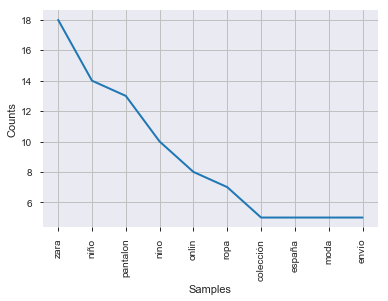

227


In [12]:
wordFreqDistGoogleResp.plot(10, cumulative=False)
print (len(processedGoogleResp))

In [13]:
# Now we have 
# - the tokenized search phrase
# - the tokenized search response
# - "wordFreqDist" as nltk.probability FreqDist of words in the response.
# - the tokenized keywords for each goal/intent in a dictionary goalNameKeywordDict

#obtain the frequency distribution of the goal keywords in the SEARCH PHRASE

goalSearchAvgDict = {}
goalSearchTotalDict = {}
goalRespAvgDict = {}
goalRespTotalDict = {}


print ("///////////SEARCH PHRASE MATCHED TO GOAL KEYWORDS///////////////////")
print ("")
for goal in goalNameKeywordDict:
   
    print ("/////////////////////////////////")
    print ("GOAL:", goal)
    print ("/////////////////////////////////")
    total = 0
    for word in goalNameKeywordDict.get(goal):
        keyword_weight = goalNameKeywordDict.get(goal).get(word)
        #The word frequency distribution of each keyword for this goal in the search phrase
        #i.e probability of the keyword being in the search phrase  
        print (word,keyword_weight, wordFreqDistSearchPhrase.freq(word))
        total = total + (wordFreqDistSearchPhrase.freq(word)/keyword_weight)
    average = total/len(goalNameKeywordDict.get(goal))  
    print("Average distribution of goal [", goal, "] keywords in the search phrase ", average)
    print("Total combined distribution of goal [", goal, "] keywords in the search phrase ", total)
    print("")
    goalSearchAvgDict [goal] = average
    goalSearchTotalDict [goal] = total
print ("")
print ("**The most likely goal according to search phrase using average:", max(goalSearchAvgDict, key=goalSearchAvgDict.get))
print ("**The most likely goal according to search phrase using total:", max(goalSearchTotalDict, key=goalSearchTotalDict.get))
print ("")


#obtain the frequency distribution of the "goal keywords" in the google response. 
print ("///////////GOOGLE SEARCH RESPONSE MATCHED TO GOAL KEYWORDS///////////////////")
print ("")
for goal in goalNameKeywordDict:
    print ("/////////////////////////////////")
    print ("GOAL:", goal)
    print ("/////////////////////////////////")
    total = 0
    for word in goalNameKeywordDict.get(goal):
        #The word frequency distribution of each keyword for this goal in the google response
        #i.e probability of the keyword being in the Google Response.
        keyword_weight = goalNameKeywordDict.get(goal).get(word)
        total = total + (wordFreqDistGoogleResp.freq(word) / keyword_weight)
        print (word, keyword_weight, wordFreqDistGoogleResp.freq(word))
    average = total/len(goalNameKeywordDict.get(goal))  
    print("Average distribution of goal [", goal, "] keywords in the response ", average)
    print("Total combined distribution of goal [", goal, "] keywords in the response ", total)
    print("")
    goalRespAvgDict [goal] = average
    goalRespTotalDict [goal] = total
print ("")
print ("**The most likely goal according to search response using average:", max(goalRespAvgDict, key=goalRespAvgDict.get))
print ("**The most likely goal according to search response using total:", max(goalRespTotalDict, key=goalRespTotalDict.get))
#END FOR


///////////SEARCH PHRASE MATCHED TO GOAL KEYWORDS///////////////////

/////////////////////////////////
GOAL: brand
/////////////////////////////////
websit 1 0.0
marca 1 0.0
producto 1 0.0
shop 1 0.0
ww 1 0.0
www 1 0.0
zara 1 0.3333333333333333
 e 1 0.0
 en 1 0.0
historia 3 0.0
 line 2 0.0
web 1 0.0
onlin 3 0.0
ropa 2 0.0
Average distribution of goal [ brand ] keywords in the search phrase  0.023809523809523808
Total combined distribution of goal [ brand ] keywords in the search phrase  0.3333333333333333

/////////////////////////////////
GOAL: transactional
/////////////////////////////////
venta 1 0.0
ropa 1 0.0
onlin 1 0.0
comprar 1 0.0
compra 1 0.0
internet 1 0.0
shop 1 0.0
tienda 1 0.0
line 1 0.0
web 2 0.0
websit 2 0.0
cuenta 1 0.0
devolucion 2 0.0
envio 2 0.0
tarjeta 1 0.0
regalo 1 0.0
zara 1 0.3333333333333333
ticket 1 0.0
Average distribution of goal [ transactional ] keywords in the search phrase  0.018518518518518517
Total combined distribution of goal [ transactional ] key

punto 1 0.0
short 1 0.0
srpl 1 0.0
sudadera 1 0.004405286343612335
top 1 0.0
traje 1 0.004405286343612335
underwear  1 0.0
vestido 1 0.004405286343612335
zapato 1 0.013215859030837005
zara 3 0.07929515418502203
Average distribution of goal [ list ] keywords in the response  0.0038870173620108844
Total combined distribution of goal [ list ] keywords in the response  0.13215859030837007

/////////////////////////////////
GOAL: locale
/////////////////////////////////
españa 1 0.022026431718061675
home 2 0.0
tienda 2 0.01762114537444934
onlin 2 0.03524229074889868
centro 1 0.00881057268722467
telefono 1 0.0
europa 1 0.0
horario 1 0.0
ciudad 1 0.0
career 1 0.0
empresa 1 0.004405286343612335
curriculum 1 0.0
zara 3 0.07929515418502203
Average distribution of goal [ locale ] keywords in the response  0.006777363605557438
Total combined distribution of goal [ locale ] keywords in the response  0.0881057268722467

/////////////////////////////////
GOAL: target
/////////////////////////////////

# Now get a combined score for search phrase and googles response

In [14]:
#Double check these calcs manually to make sure the implementatino is correct, here we apply a weight of 1.5 to the goal
#scores generated by the search phrase, this is to give the search phrase more impact in terms of identifying the goal
#than the response has, set to 1 for no impact.

extraWeightForSearchPhrase = 1.5
print  (goalRespAvgDict)
print  (goalSearchAvgDict)
print("")

############################
# Method used to combine the two scores per goal(stored in dictionary) and add a weight(extraWeight) to
# the scores from the Search phrase score
###########################
def mergsum(googleRespScores, searchPhraseScores, extraWeight):
    res = {}
    combined = {}
    for k in searchPhraseScores:
        if k in googleRespScores:
            searchPhraseScores[k] = (searchPhraseScores[k]*extraWeight) + googleRespScores[k]
    #res = {**googleRespScores, **searchPhraseScores}
    #return res
    print (searchPhraseScores)
    return searchPhraseScores

print("USING AVERAGE SCORE PER KEYWORD")
c = mergsum(goalRespAvgDict, goalSearchAvgDict, extraWeightForSearchPhrase )


print("")
print("USING SUM/TOTAL OF SCORES PER KEYWORD")
d = mergsum(goalRespTotalDict, goalSearchTotalDict, extraWeightForSearchPhrase )



print ("")
print ("**Using a Score that is combination of search phrase goal score and google response goal score ")
print ("**The most likely goal using the average approach:", max(c, key=c.get))
print ("**The most likely goal using the total approach:", max(d, key=d.get))
#END FOR

{'brand': 0.007919026641493602, 'transactional': 0.010890846793930497, 'entertaiment': 0.003775959723096287, 'obtain': 0.0022026431718061676, 'advise': 0.0036221243269701424, 'deals': 0.006777363605557438, 'gender': 0.007285665875974247, 'list': 0.0038870173620108844, 'locale': 0.006777363605557438, 'target': 0.0144745122718691, 'trends': 0.005781938325991189}
{'brand': 0.023809523809523808, 'transactional': 0.018518518518518517, 'entertaiment': 0.007936507936507936, 'obtain': 0.009259259259259259, 'advise': 0.007407407407407407, 'deals': 0.02564102564102564, 'gender': 0.021367521367521368, 'list': 0.0130718954248366, 'locale': 0.008547008547008546, 'target': 0.06349206349206349, 'trends': 0.006944444444444444}

USING AVERAGE SCORE PER KEYWORD
{'brand': 0.043633312355779316, 'transactional': 0.03866862457170828, 'entertaiment': 0.01568072162785819, 'obtain': 0.016091532060695055, 'advise': 0.014733235438081253, 'deals': 0.0452389020670959, 'gender': 0.0393369479272563, 'list': 0.023494

# The AdWords "Keyword" column

The "Keyword" column tells you which one of your keywords matched someone’s search term and triggered your ad. This information can help you see your keywords “in action” by showing you how they are matching to actual searches. 

You can use the data in the "Keyword" column to improve your keyword list. For example, let’s say you sell tulips. When you look at your search terms report, you see that your broad match keyword flowers triggers your ad to show when people search for red roses and purple orchids -- flowers you don’t sell. So, you decide to refine your keyword list to focus on terms and phrases more specific to the products you do offer: tulips.

Note for AdWord settings ... The "Keyword" column does not show by default. In the previous AdWords experience, turn on the “Keyword” column by clicking the Columns drop down menu and choosing “Modify columns.” In the "Select metrics" section, click Attributes. Then, click the Add link next to "Keyword" and click Apply. In the new Google Ads experience, turn on the “Keyword” column by clicking the column icon Columns, then clicking Attributes. Tick the box beside “Keyword,” then click Apply.

# Machine learning approach
similar to learning to rank algorithm. 
Training data is used by a learning algorithm to produce a ranking model which computes the relevance of documents for actual queries.(In this case it would compute the relevance of search keywords to search intentions.

To populate the training data we couuld as per phase 1 compute the relevance of search responses to search intention keywords to provide the labels for training/test search queries. the overall implementation could be that when we enter a search query the search engine will predict our search intention/goal before submitting the query. this can also be used to further train the algorithm if we give possibility to corret the prediction.





